### Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import cython
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import h5py
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import data, exposure
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.models import Sequential

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


### Disclaimer 


To test the code, we used kaggle, so it is first necessary to import in kaggle the original .zip file containing the original dataset.
A second option could be using Google Drive. In orde to use it is necesssary to mount the drive, import the original .zip file, unzip it and move inside the directory created. The following lines of code will do this. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
%cd /gdrive/My Drive/Colab Notebooks/Challenge1

In [ ]:
!unzip training_dataset_homework1.zip

In [ ]:
dataset_dir = 'training_data_final'

## Set Seed for Reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Suppress Warnings

In [3]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Dataset

Image size: 96x96
Color space: RGB (read as 'rgb' in ImageDataGenerator.flow_from_directory ('color_mode' attribute) or use PIL.Image.open('imgname.jpg').convert('RGB'))
File Format: JPG
Number of classes: 8
Classes:
0: "Species1"
1: "Species2"
2: "Species3"
3: "Species4"
4: "Species5"
5: "Species6"
6: "Species7"
7: "Species8"

In [4]:
dataset_dir = '/kaggle/input/dataset/training_data_final'

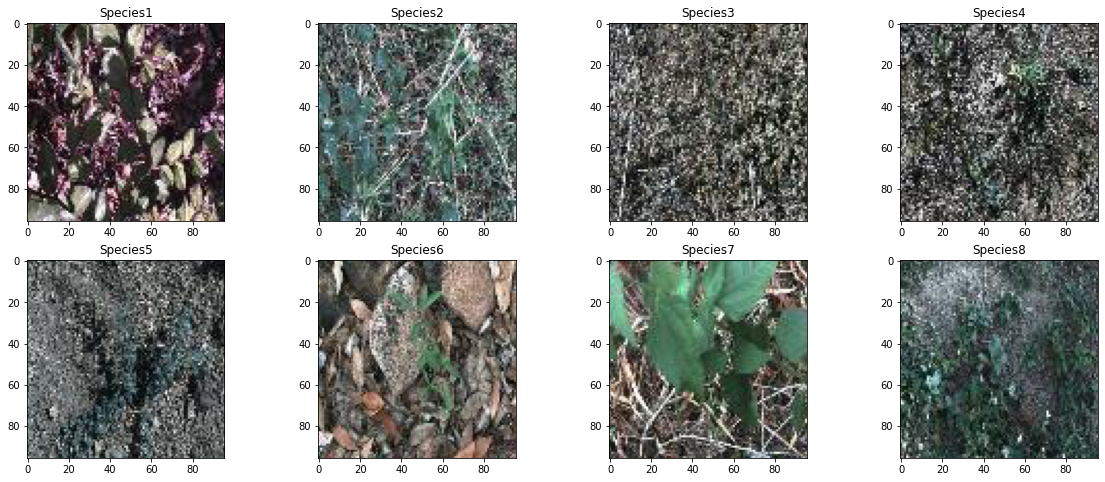

In [76]:
labels = {0:'Species1', 1:'Species2', 2:'Species3', 3:'Species4', 4:'Species5', 5:'Species6', 6:'Species7', 7:'Species8'}

# Inspect the data, Plot of the FIRST ELEMENT of each CLASS(Species)
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    if i < 8:
        class_imgs = next(os.walk(dataset_dir + '/{}/'.format(labels[i])))[2]
        class_imgs.sort()
        class_img = class_imgs[0]
        img = Image.open(dataset_dir + '/{}/{}'.format(labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
plt.tight_layout
plt.show()

## Dataset Loader

In [6]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.

train_data_gen = ImageDataGenerator()
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True, #we shuffle at each epoch
                                               seed=seed)

Found 3542 images belonging to 8 classes.


In [7]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [8]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]

    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

      # Visualize only the first sample
    image = image[0]

    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.uint8(image))

(Input) image shape: (8, 96, 96, 3)
Target shape: (8, 8)

Categorical label: [0. 0. 0. 0. 1. 0. 0. 0.]
Label: 4
Class name: Species5


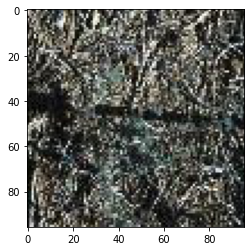

In [9]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

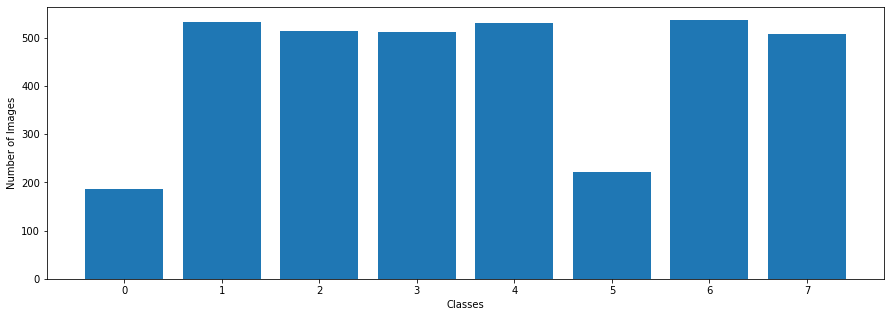

Counting occurrences of target classes: 

Total occurences of Class 0 images:  186
Total occurences of Class 1 images:  532
Total occurences of Class 2 images:  515
Total occurences of Class 3 images:  511
Total occurences of Class 4 images:  531
Total occurences of Class 5 images:  222
Total occurences of Class 6 images:  537
Total occurences of Class 7 images:  508


In [10]:
#plotting the bar diagram with the number of images in each class 
plt.figure(figsize=(15,5))
labels, counts = np.unique(train_gen.classes, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

print('Counting occurrences of target classes: \n')
count_arr = np.bincount(train_gen.classes)
print('Total occurences of Class 0 images: ', count_arr[0])
print('Total occurences of Class 1 images: ', count_arr[1])
print('Total occurences of Class 2 images: ', count_arr[2])
print('Total occurences of Class 3 images: ', count_arr[3])
print('Total occurences of Class 4 images: ', count_arr[4])
print('Total occurences of Class 5 images: ', count_arr[5])
print('Total occurences of Class 6 images: ', count_arr[6])
print('Total occurences of Class 7 images: ', count_arr[7])

## Offline Data Augmentation

Here is reported the code used for applying data offline augmentation as descriped in the .pdf report. We made some attempts by training models with this "new" dataset as well as with online augmentation without seeing any improvement with respect to the case where we used just online augmentation. So we keep the original dataset plus only online data augmentation.

### Splitting in Train and Validation

In [11]:
# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(validation_split = 0.2)

train_generator = train_data_gen.flow_from_directory(
    dataset_dir,
    target_size=(96,96),
    color_mode='rgb',
    classes = None,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=seed) # set as training data

validation_generator = train_data_gen.flow_from_directory(
    dataset_dir, # same directory as training data
    target_size=(96,96),
    color_mode='rgb',
    classes = None,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=seed) # set as validation data

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [12]:
print("Assigned labels")
print(train_generator.class_indices)
print("Target classes")
print(len(train_generator.classes))
print("\n")
print("Assigned labels")
print(validation_generator.class_indices)
print("Target classes")
print(len(validation_generator.classes))

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}
Target classes
2836


Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}
Target classes
706


In [14]:
#this is the offline creation of the folders for training and validation. In each folder we recreated the class subfolders containing 
#the corresponding images given from the flow_from_directory splitting.
path_to_new_dir = "splitted_dataset"

if not os.path.exists(path_to_new_dir):
    os.makedirs(path_to_new_dir)

train_path = os.path.join(path_to_new_dir, "training")
val_path = os.path.join(path_to_new_dir, "validation")

if not os.path.exists(train_path):
    os.makedirs(train_path)
if not os.path.exists(val_path):
    os.makedirs(val_path)

_, dirs, _ = next(os.walk(dataset_dir))
dirs.sort()

for i in range(len(dirs)):
    path_to_original = os.path.join(dataset_dir, dirs[i])

    path_to_save_train_spec = os.path.join(train_path, dirs[i])
    path_to_save_val_spec = os.path.join(val_path, dirs[i])
  #creates dir
    if not os.path.exists(path_to_save_train_spec):
        os.makedirs(path_to_save_train_spec)
    if not os.path.exists(path_to_save_val_spec):
        os.makedirs(path_to_save_val_spec)

for i in range(len(train_generator.filepaths)):
    temp = train_generator.filepaths[i].replace("training_data_final", path_to_new_dir + "/training")
    os.replace(train_generator.filepaths[i], temp)

for i in range(len(validation_generator.filepaths)):
    temp = validation_generator.filepaths[i].replace("training_data_final", path_to_new_dir + "/validation")
    os.replace(validation_generator.filepaths[i], temp)

### Oversampling

In [15]:
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
new_dataset_dir = "splitted_dataset"

In [ ]:
#in this case we created a way to oversampling the classes with fewer data (Species1 and Species6). We calculated the integers by which
#this two classes should have been oversampled in order to reach approximately 450 images (which is the number of images in other classes)
#after the train - validation splliting. Notice that this process has to be done only for training images and not validation.
#In this way, it is also possilbe to set a higher threshold so that each in each class will be multiplied by a factor in order to reach 
#this number, oversampling all its data.
#In this case inside the ImageDataGenerator we inserted an irrelevant data augmentation so that all the copies generated will be identical
#to the raw image.

threshold = 450

gen = ImageDataGenerator(height_shift_range = 0.001,
                         fill_mode = 'reflect',
                         )

directories = os.listdir(new_dataset_dir + '/training')
directories.sort()

lengths = []
for dir in directories:
    path = new_dataset_dir + '/training/' + dir
    imgs = os.listdir(path)
    lengths.append(len(imgs))

mul_frac = []
for num in lengths:
    temp = np.ceil(threshold / num)
    mul_frac.append(temp)
print(mul_frac)

j=0
for dir in directories:
    path = new_dataset_dir + '/training/' + dir
    imgs = os.listdir(path)

    for img in imgs:
        img_name = path + '/' + img
        if(img_name.endswith('.jpg')):
            immagine = load_img(img_name)
            x = img_to_array(immagine)
            x = x.reshape((1,) + x.shape)
            i=0
            for batch in gen.flow(x, batch_size = 1):
                image = batch[0].astype('uint8')
                result = Image.fromarray(image)
                image_name = path + '/aug_' + img[:-4] + '_%i.jpg'%(i)
                result.save(image_name)
                i+=1
                if i> (mul_frac[j] - 2):
                    break
    j=j+1

In [ ]:
#this is code can be used if someone wants to level all the classes to the same number of images. In this case from each class will
#be deleted a random augmented image so that to reach the value of the threshold set before
directories = os.listdir(new_dataset_dir + '/training')
for dir in directories:
    path = new_dataset_dir + '/training/' + dir
    imgs = os.listdir(path)
    random.seed(seed)
    while(len(imgs) > threshold):
        random_image = random.choice(imgs)
        if random_image.startswith('aug'):
            os.remove(path + '/' + random_image)
        imgs = os.listdir(path)

In [ ]:
#printing the number of images in each class
directories = os.listdir(new_dataset_dir + '/training')
for dir in directories:
    path = new_dataset_dir + '/training/' + dir
    imgs = os.listdir(path)
    print(len(imgs))

In [ ]:
#plotting the bar diagram with the number of images in each class 
train_data_gen = ImageDataGenerator()
train_gen = train_data_gen.flow_from_directory(directory=new_dataset_dir + '/training',
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True, #we shuffle at each epoch
                                               seed=seed)

# Inspect the target
plt.figure(figsize=(15,5))
labels, counts = np.unique(train_gen.classes, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

print('Counting occurrences of target classes: \n')
count_arr = np.bincount(train_gen.classes)
print('Total occurences of Class 0 images: ', count_arr[0])
print('Total occurences of Class 1 images: ', count_arr[1])
print('Total occurences of Class 2 images: ', count_arr[2])
print('Total occurences of Class 3 images: ', count_arr[3])
print('Total occurences of Class 4 images: ', count_arr[4])
print('Total occurences of Class 5 images: ', count_arr[5])
print('Total occurences of Class 6 images: ', count_arr[6])
print('Total occurences of Class 7 images: ', count_arr[7])

## Online Data Augmentation

In [16]:
from tensorflow.keras.applications.densenet  import preprocess_input

#we tried to use this function, as stated in the report, in order to trying to apply a preprocessing to each image, to see the results,
#in this case in particular we applied an histogram equalization in order to improve the contrast and better highlight the plants.
#unfortunately this didn't help in getting better validation accuracy.

def preprocessing_input(filename):
    image = np.array(filename)
    p2, p98 = np.percentile(image, (2, 98))
    img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
    return img_rescale

aug_train_data_gen = ImageDataGenerator(
                                        rotation_range=30,
                                        height_shift_range=0.3,
                                        width_shift_range=0.3,
                                        zoom_range=0.3,
                                        shear_range=0.3,
                                        brightness_range = [0.5, 1.5],
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        validation_split=0.2,
#                                         preprocessing_function = preprocess_input, #this must be used in case the specific model for transfer learning requires it, check the documentation 
                                         #rescale = 1/255.  #this must be uncommented if we are using a model built by us
                                        )

valid_data_gen = ImageDataGenerator(
#                                     preprocessing_function = preprocess_input, #this must be used in case the specific model for transfer learning requires it, check the documentation
                                   # rescale = 1/255.,  #this must be uncommented if we are using a model built by us
                                    validation_split=0.2,
                                    )

aug_train = aug_train_data_gen.flow_from_directory(directory=dataset_dir,
                                                       target_size=(96, 96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=128,
                                                       shuffle=True,
                                                       seed=seed,
                                                       subset='training'
                                                      )


aug_valid = valid_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96, 96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=128,
                                               shuffle=False,
                                               seed=seed,
                                               subset='validation'
                                              )

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


## Callbacks and Folders

In [17]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

    exps_dir = os.path.join('data_augmentation_experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
      
    callbacks = []

  # Model checkpoint
  # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  #callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
    callbacks.append(tb_callback)

  # Early Stopping
  # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)

#     lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
#                                                  mode="min",
#                                                  min_lr=0.00001,
#                                                  factor=.35,
#                                                  patience=3,
#                                                  verbose=1)
#     callbacks.append(lr_callback)


    return callbacks

## Model from Scratch (VGG19)

In [18]:
input_shape = (96, 96, 3)
epochs = 200

In [26]:
def build_model(input_shape):
 
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
 
    conv1 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv1)
    pool1= tfkl.MaxPooling2D(pool_size = (2, 2), strides=(2,2))(conv2)
################################################################################################
    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv3)
    pool2= tfkl.MaxPooling2D(pool_size = (2, 2), strides=(2,2))(conv4)
##################################################################################################
    
    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    conv6 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv5)
    conv7 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv6)
    conv8 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv7)
    pool3= tfkl.MaxPooling2D(pool_size = (2, 2), strides=(2,2))(conv8)
    
##################################################################################################
    
    conv9 = tfkl.Conv2D(
        filters=512,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    conv10 = tfkl.Conv2D(
        filters=512,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv9)
    conv11 = tfkl.Conv2D(
        filters=512,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv10)
    conv12 = tfkl.Conv2D(
        filters=512,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv11)
    pool4= tfkl.MaxPooling2D(pool_size = (2, 2), strides=(2,2))(conv12)

##################################################################################################
    
    conv13 = tfkl.Conv2D(
        filters=512,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    conv14 = tfkl.Conv2D(
        filters=512,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv13)
    conv15 = tfkl.Conv2D(
        filters=512,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv14)
    conv16 = tfkl.Conv2D(
        filters=512,
        kernel_size=(3,3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv15)
    pool5= tfkl.MaxPooling2D(pool_size = (2, 2), strides=(2,2))(conv16)
    
    ##############################################################################################
    
    flatten = tfkl.Flatten()(pool5)

    classifier_layer1 = tfkl.Dense(
        units=4096, name='Classifier1',                            
        kernel_initializer=tfk.initializers.HeUniform(seed),
        activation='relu'
    )(flatten)
    dropout1 = tfkl.Dropout(0.5, seed=seed)(classifier_layer1)
    
    classifier_layer2 = tfkl.Dense(
        units=4096, name='Classifier2',
        kernel_initializer=tfk.initializers.HeUniform(seed),
        activation='relu'
    )(dropout1)
    dropout2 = tfkl.Dropout(0.5, seed=seed)(classifier_layer2)

    output_layer = tfkl.Dense(
        units=8, activation='softmax',
        kernel_initializer=tfk.initializers.GlorotUniform(seed)
        ,name='output_layer'
    )(dropout2)
 
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
 
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.001), metrics='accuracy')
 
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 96, 96, 64)        1792      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 128)       0     

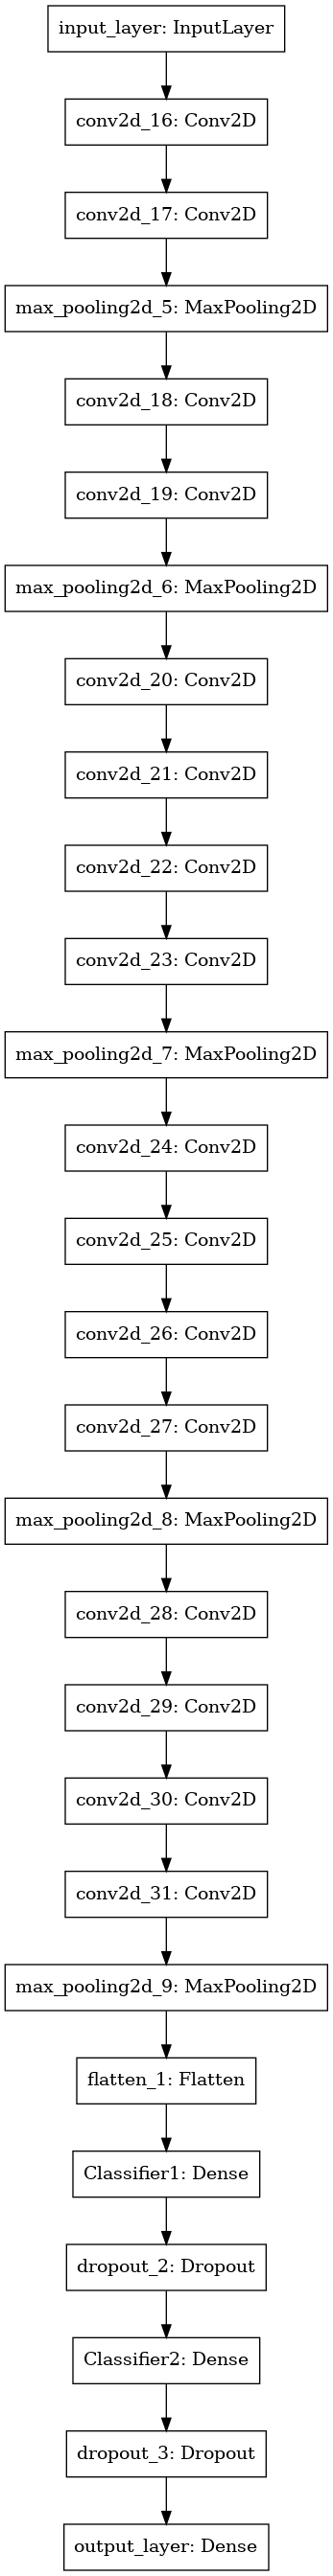

In [27]:
vgg_19_model = build_model(input_shape)
vgg_19_model.summary()
tfk.utils.plot_model(vgg_19_model)

In [28]:
aug_callbacks = create_folders_and_callbacks(model_name='CNN2lev_drop')

### Class Weights

As described in the report, we tried to implement class weights in order to mitigate the problem of imbalance, unfortunately this didn't help in resolving it

In [29]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight  = 'balanced',
                                                 classes = np.unique(aug_train.classes),
                                                 y = aug_train.classes)
class_weights = dict(zip(np.unique(aug_train.classes), class_weights))
print(class_weights)

{0: 2.379194630872483, 1: 0.8321596244131455, 2: 0.8604368932038835, 3: 0.8667481662591687, 4: 0.8341176470588235, 5: 1.9915730337078652, 6: 0.8244186046511628, 7: 0.871007371007371}


In [ ]:
vgg_19_history = vgg_19_model.fit(
    x = aug_train,
    epochs = 200,
    validation_data = aug_valid,
    callbacks = aug_callbacks,
    #class_weight = class_weights
).history

In [ ]:
vgg_19_model.save("/kaggle/working/vgg_19_model_from_scratch")

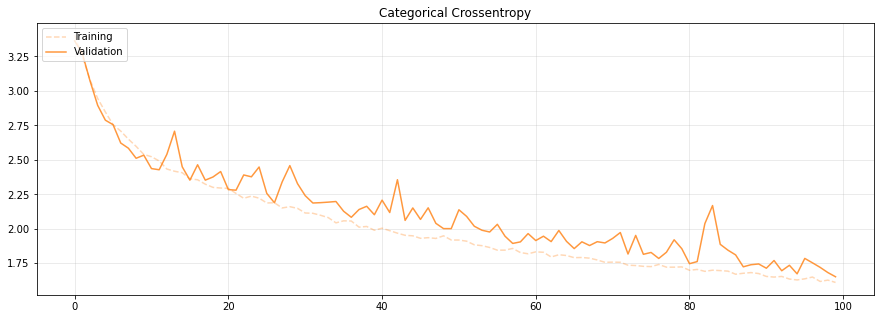

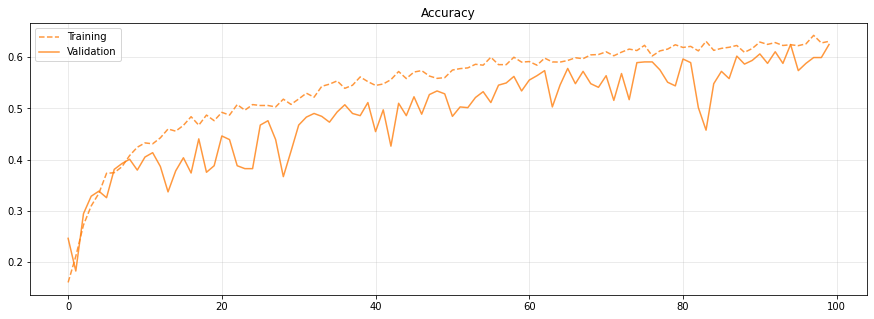

In [27]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(vgg_19_history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(vgg_19_history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(vgg_19_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(vgg_19_history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [36]:
results = vgg_19_history.evaluate(aug_valid)
print(results)

23/23 [==============================] - 1s 61ms/step - loss: 1.6523 - accuracy: 0.6246
[1.652288556098938, 0.6246458888053894]


## Transfer Learning

In [37]:
from keras.applications.efficientnet import EfficientNetB4, preprocess_input
from keras.layers import Input,Dense,Flatten, Dropout, BatchNormalization, Activation
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

### EfficientNetB4

In [38]:
#As stated in the report, we tried to use the image weights and the noisy student. The first ones showed the best results

IMAGE_SIZE = [ 96 , 96 , 3 ]

# Load the model 
eff_net_b4 = EfficientNetB4(include_top = False,
            input_shape = IMAGE_SIZE,
            weights = 'imagenet',
            #weights = '/kaggle/input/weights_noisy_students/efficientnet-b4_noisy-student_notop.h5'
                    )

# Visualize the model
eff_net_b4.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 96, 96, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 96, 96, 3)    7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 97, 97, 3)    0           normalization_1[0][0]            
_____________________________________________________________________________________

In [35]:
#freezing all the model in order to do transfer learning
eff_net_b4.trainable = False

In [39]:
inputs = tfk.Input(shape=(96,96,3))

#training = False makes sure that the base_model is running in inference mode here.
#When you set bn_layer.trainable = False, the BatchNormalization layer will run in inference mode, 
#and will not update its mean & variance statistics. This is not the case for other layers in general, as
#weight trainability & inference/training modes are two orthogonal concepts. But the two are tied in the case of the 
#BatchNormalization layer. When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning,
#you should keep th BatchNormalization layers in inference mode by passing training=False when calling the base model. 
#Otherwise the updates applied to the non-trainable weights will suddenly destroy what the model has learned.

x = eff_net_b4(inputs, training=False)       
x = tfkl.GlobalAveragePooling2D()(x)
# x = tfkl.BatchNormalization()(x)
# x = tfkl.Dropout(0.3, seed=seed)(x)
# x = tfkl.Dense(
#         units=128, name='Classifier1',                            
#         kernel_initializer=tfk.initializers.HeUniform(seed),
#         activation='relu'
#     )(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
        units=128, name='Classifier1',                            
        kernel_initializer=tfk.initializers.HeUniform(seed),
        activation='relu'
    )(x)
x = tfkl.BatchNormalization()(x)
# x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
        units=8, activation='softmax',
       kernel_initializer=tfk.initializers.GlorotUniform(seed),
        name='output_layer'
    )(x)

model_transf = tfk.Model(inputs=inputs, outputs=outputs, name='model')

model_transf.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')
model_transf.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 3, 3, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1792)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1792)              7168      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1792)              0         
_________________________________________________________________
Classifier1 (Dense)          (None, 128)               229504    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512   

In [62]:
# Train the model
standard_history = model_transf.fit(
    x = aug_train,
    epochs = epochs,
    validation_data = aug_valid,
    callbacks = aug_callbacks,
   #class_weight = class_weights
).history

Epoch 1/200
89/89 [==============================] - 20s 177ms/step - loss: 1.7197 - accuracy: 0.4291 - val_loss: 1.4556 - val_accuracy: 0.4972
Epoch 2/200
89/89 [==============================] - 15s 164ms/step - loss: 1.2890 - accuracy: 0.5381 - val_loss: 1.2189 - val_accuracy: 0.5439
Epoch 3/200
89/89 [==============================] - 14s 161ms/step - loss: 1.1807 - accuracy: 0.5815 - val_loss: 1.0572 - val_accuracy: 0.6232
Epoch 4/200
89/89 [==============================] - 15s 164ms/step - loss: 1.1292 - accuracy: 0.5984 - val_loss: 1.0227 - val_accuracy: 0.6261
Epoch 5/200
89/89 [==============================] - 15s 164ms/step - loss: 1.1032 - accuracy: 0.6146 - val_loss: 1.0851 - val_accuracy: 0.5963
Epoch 6/200
89/89 [==============================] - 15s 165ms/step - loss: 1.0753 - accuracy: 0.6224 - val_loss: 0.9788 - val_accuracy: 0.6459
Epoch 7/200
89/89 [==============================] - 15s 166ms/step - loss: 1.0575 - accuracy: 0.6217 - val_loss: 0.9662 - val_accuracy:

In [ ]:
model_transf.save('/kaggle/working/effnetb4_transf_learning')

### Creating Zips

In [ ]:
from IPython.display import FileLink
!zip -r effnetb4_transf_learning.zip /kaggle/working/effnetb4_transf_learning
FileLink(r'effnetb4_transf_learning.zip')

In [42]:
model_fine_tu = tfk.models.load_model('/kaggle/output/effnetb4_transf_learning')

## Fine Tuning

In [43]:
#show the layers and their trainability
for i, layer in enumerate(model_fine_tu.get_layer('efficientnetb4').layers):
    print(i, layer.name, layer.trainable)

0 input_33 True
1 rescaling_10 False
2 normalization_10 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False
37 block2a_se_reshape False
38 block2a_se_reduce False
39 block2a

In [45]:
def unfreeze_model(model):
    # We unfreeze the top 60 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-75:]:
        if not isinstance(layer, tfk.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model_fine_tu)
model_fine_tu.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 3, 3, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d_22  (None, 1792)              0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 1792)              7168      
_________________________________________________________________
dropout_27 (Dropout)         (None, 1792)              0         
_________________________________________________________________
Classifier2 (Dense)          (None, 128)               229504    
_________________________________________________________________
batch_normalization_39 (Batc (None, 128)               512   

In [71]:
# Train the model
standard_history = model_fine_tu.fit(
    x = aug_train,
    epochs = 200,
    validation_data = aug_valid,
    callbacks = aug_callbacks,
).history

Epoch 1/200
23/23 [==============================] - 19s 312ms/step - loss: 0.7399 - accuracy: 0.7306 - val_loss: 0.8009 - val_accuracy: 0.7181
Epoch 2/200
23/23 [==============================] - 6s 238ms/step - loss: 0.5957 - accuracy: 0.7951 - val_loss: 0.7431 - val_accuracy: 0.7479
Epoch 3/200
23/23 [==============================] - 5s 225ms/step - loss: 0.5426 - accuracy: 0.8216 - val_loss: 0.6376 - val_accuracy: 0.7790
Epoch 4/200
23/23 [==============================] - 5s 232ms/step - loss: 0.4961 - accuracy: 0.8382 - val_loss: 0.6022 - val_accuracy: 0.7918
Epoch 5/200
23/23 [==============================] - 6s 251ms/step - loss: 0.4569 - accuracy: 0.8512 - val_loss: 0.5783 - val_accuracy: 0.7960
Epoch 6/200
23/23 [==============================] - 5s 227ms/step - loss: 0.4149 - accuracy: 0.8717 - val_loss: 0.5528 - val_accuracy: 0.8187
Epoch 7/200
23/23 [==============================] - 6s 254ms/step - loss: 0.3978 - accuracy: 0.8734 - val_loss: 0.5357 - val_accuracy: 0.821

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(standard_history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(standard_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [44]:
model_fine_tu.save('/kaggle/working/effnetb4_fine_tuning')

In [81]:
# Trained with data augmentation
model_aug_test_metrics = model_fine_tu.evaluate(aug_valid, return_dict=True)

print()
print("Test metrics with data augmentation")
print(model_aug_test_metrics)

6/6 [==============================] - 1s 152ms/step - loss: 0.3371 - accuracy: 0.8867

Test metrics with data augmentation
{'loss': 0.33712318539619446, 'accuracy': 0.8866855502128601}


In [ ]:
from IPython.display import FileLink
!zip -r effnetb4_fine_tuning.zip /kaggle/working/effnetb4_fine_tuning
FileLink(r'effnetb4_fine_tuning.zip')

### Visualize Predictions

In [89]:
predictions = model_fine_tu.predict(aug_valid)
aug_valid_true = aug_valid.classes.reshape(aug_valid.classes.shape[0],1)

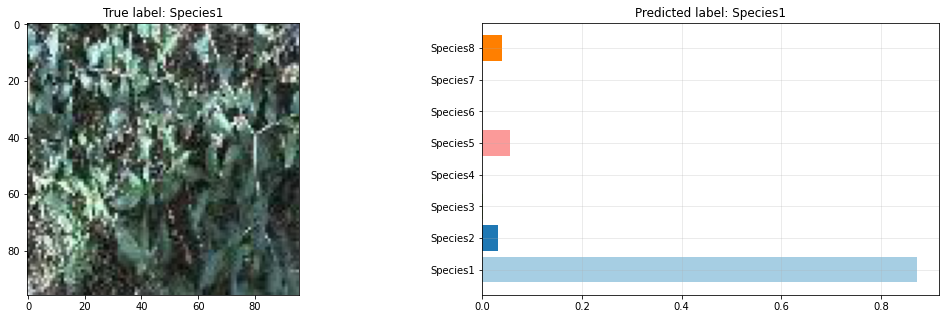

In [99]:
# Plot the target images and the predictions
prediction_index = 10

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,5)
ax1.imshow(np.uint8(aug_valid[0][0][prediction_index]))
ax1.set_title('True label: '+labels[np.argmax(aug_valid_true[prediction_index])])
ax2.barh(list(labels.values()), predictions[prediction_index], color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: '+labels[np.argmax(predictions[prediction_index])])
ax2.grid(alpha=.3)
plt.show()